In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

Загрузка и предобработка данных, работа с признаками

In [39]:
df_train = pd.read_csv('playground-series-s4e10/train.csv')
df_test = pd.read_csv('playground-series-s4e10/test.csv')

features_num = df_train[['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                         'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']]
features_cat = pd.get_dummies(df_train[['person_home_ownership', 'loan_intent',
                                        'loan_grade', 'cb_person_default_on_file']], drop_first=True)

features_train = pd.concat([features_num, features_cat], axis=1)
target_train = df_train[['loan_status']]
X_train, X_val, y_train, y_val = train_test_split(features_train, target_train, test_size=0.2, random_state=1)

features_num_test = df_test[['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                         'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']]
features_cat_test = pd.get_dummies(df_test[['person_home_ownership', 'loan_intent',
                                        'loan_grade', 'cb_person_default_on_file']], drop_first=True)

test = pd.concat([features_num_test, features_cat_test], axis=1)

In [40]:
col = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

scaler_X = StandardScaler()

X_train[col] = scaler_X.fit_transform(X_train[col])
X_val[col] = scaler_X.transform(X_val[col])
test[col] = scaler_X.transform(test[col])

Матрица корреляций

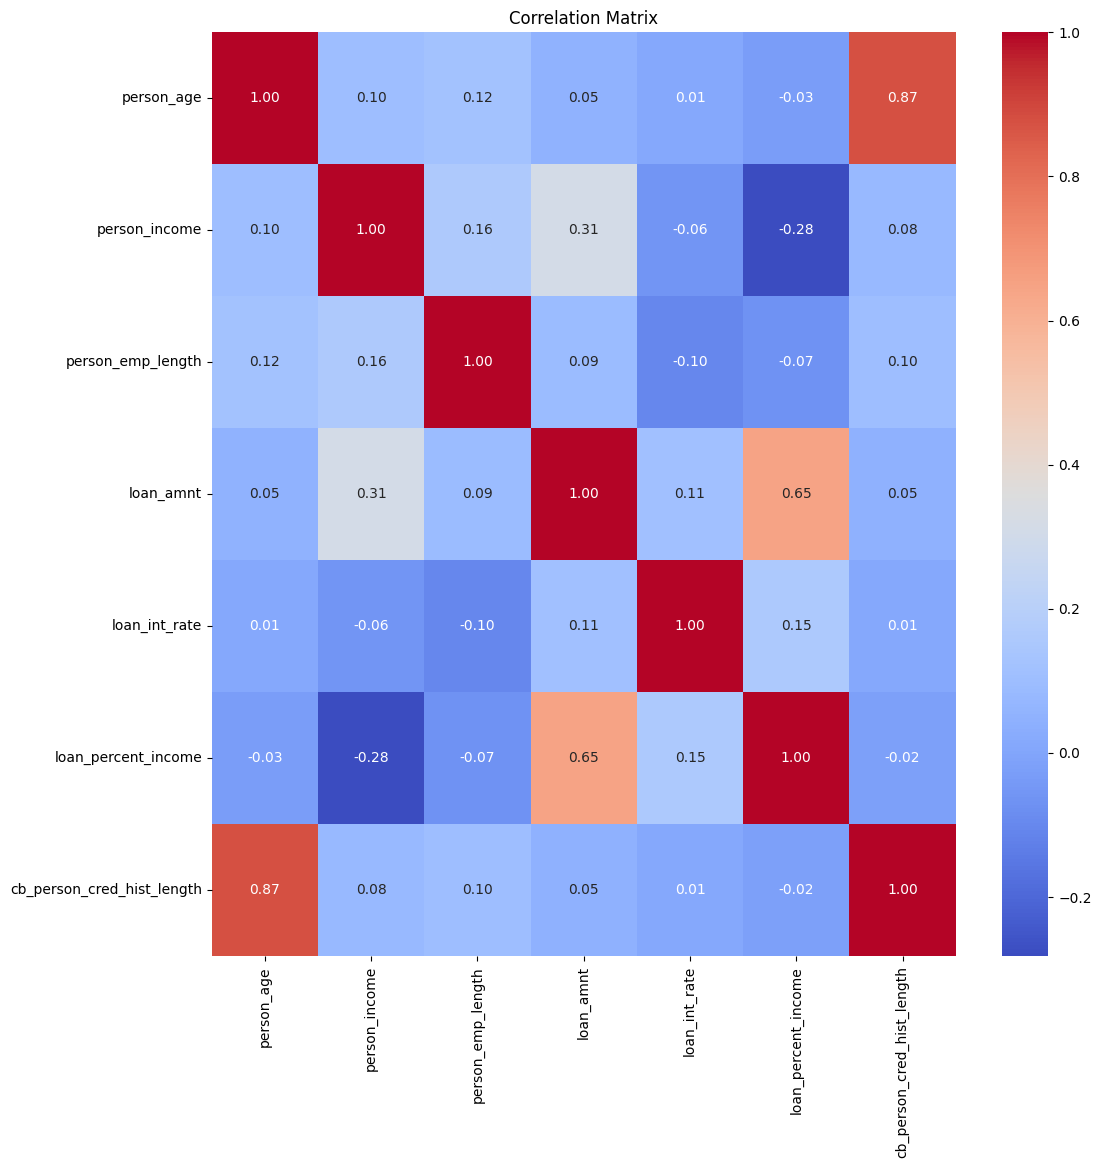

In [41]:
corr_matrix = X_train[col].corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Поиск наилучшей модели, учитывая матрицу корреляций, добавление полиномиальных признаков, если надо

In [42]:
def poly_feature(X_train_, X_val_, col_):
    poly=PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_[col_])
    X_val_poly = poly.transform(X_val_[col_])

    poly_feature_names = poly.get_feature_names_out(col_)

    X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train_.index)
    X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly_feature_names, index=X_val_.index)

    X_train_final = pd.concat([X_train_poly_df, X_train_.drop(columns=col_)], axis=1)
    X_val_final = pd.concat([X_val_poly_df, X_val_.drop(columns=col_)], axis=1)

    return X_train_final, X_val_final


In [43]:
def best_model(X_train_, X_val_):
    maxx = 0
    modell = ''

    # Random Forest
    model = RandomForestClassifier()
    model.fit(X_train_, y_train)
    predict = model.predict(X_val_)
    RF_f1 = f1_score(y_val, predict)
    if maxx < RF_f1:
        maxx = RF_f1
        modell = 'RF'

    # XGBoost
    model = XGBClassifier()
    model.fit(X_train_, y_train)
    predict = model.predict(X_val_)
    XGB_f1 = f1_score(y_val, predict)
    if maxx < XGB_f1:
        maxx = XGB_f1
        modell = 'XGB'

    # Logistic Regression
    model = LogisticRegression()
    model.fit(X_train_, y_train)
    predict = model.predict(X_val_)
    LR_f1 = f1_score(y_val, predict)
    if maxx < LR_f1:
        maxx = LR_f1
        modell = 'LR'

    # KNN
    model = KNeighborsClassifier()
    model.fit(X_train_, y_train)
    predict = model.predict(X_val_)
    KNN_f1 = f1_score(y_val, predict)
    if maxx < KNN_f1:
        maxx = KNN_f1
        modell = 'KNN'

    # Decision Tree
    model = DecisionTreeClassifier()
    model.fit(X_train_, y_train)
    predict = model.predict(X_val_)
    DT_f1 = f1_score(y_val, predict)
    if maxx < DT_f1:
        maxx = DT_f1
        modell = 'DT'

    return maxx, modell

/Users/evabankeeva/Study/PAC/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/evabankeeva/Study/PAC/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/evabankeeva/Study/PAC/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pleas

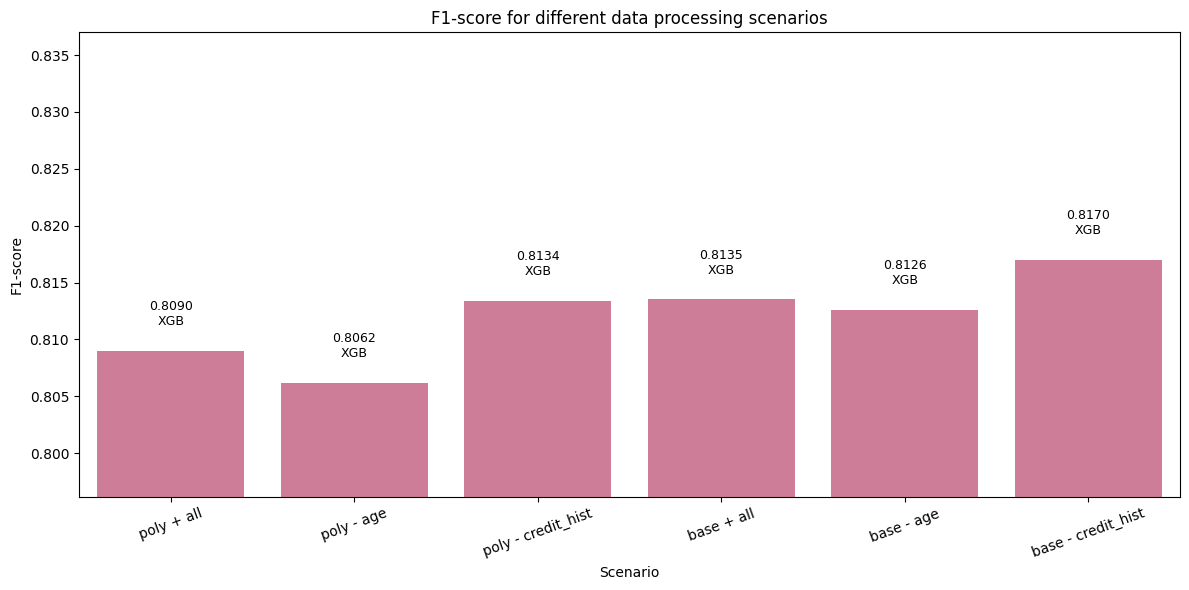

In [44]:
# полином + без кор
col = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
new_X_train, new_X_val = poly_feature(X_train, X_val, col)

f1_poly_cor, model_poly_cor = best_model(new_X_train, new_X_val)


# полином + -person_age
col = ['person_income', 'person_emp_length', 'loan_amnt',
        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
temp_X_train = X_train.drop('person_age', axis=1)
temp_X_val = X_val.drop('person_age', axis=1)
new_X_train, new_X_val = poly_feature(temp_X_train, temp_X_val, col)

f1_poly_pa, model_poly_pa = best_model(new_X_train, new_X_val)


# полином + -cb_person_cred_hist_length
col = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
        'loan_int_rate', 'loan_percent_income']
temp_X_train = X_train.drop('cb_person_cred_hist_length', axis=1)
temp_X_val = X_val.drop('cb_person_cred_hist_length', axis=1)
new_X_train, new_X_val = poly_feature(temp_X_train, temp_X_val, col)

f1_poly_cp, model_poly_cp = best_model(new_X_train, new_X_val)


# без полином + без кор
f1_base, model_base = best_model(X_train, X_val)


# без полином + -person_age
temp_X_train = X_train.drop('person_age', axis=1)
temp_X_val = X_val.drop('person_age', axis=1)
f1_pa, model_pa = best_model(temp_X_train, temp_X_val)


# без полином + -cb_person_cred_hist_length
temp_X_train = X_train.drop('cb_person_cred_hist_length', axis=1)
temp_X_val = X_val.drop('cb_person_cred_hist_length', axis=1)
f1_cp, model_cp = best_model(temp_X_train, temp_X_val)


results = pd.DataFrame({
    'scenario': [
        'poly + all',
        'poly - age',
        'poly - credit_hist',
        'base + all',
        'base - age',
        'base - credit_hist'
    ],
    'f1': [
        f1_poly_cor,
        f1_poly_pa,
        f1_poly_cp,
        f1_base,
        f1_pa,
        f1_cp
    ],
    'model': [
        model_poly_cor,
        model_poly_pa,
        model_poly_cp,
        model_base,
        model_pa,
        model_cp
    ]
})

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=results, x='scenario', y='f1', color='#DB7093')

for i, row in results.iterrows():
    ax.text(
        i,
        row['f1'] + 0.002,
        f"{row['f1']:.4f}\n{row['model']}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('F1-score for different data processing scenarios')
plt.ylabel('F1-score')
plt.xlabel('Scenario')

plt.ylim(
    results['f1'].min() - 0.01,
    results['f1'].max() + 0.02
)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [45]:
X_train = X_train.drop('cb_person_cred_hist_length', axis=1)
X_val = X_val.drop('cb_person_cred_hist_length', axis=1)
test = test.drop('cb_person_cred_hist_length', axis=1)

model = XGBClassifier()
model.fit(X_train, y_train)
predict = model.predict(X_val)

XGB_f1 = f1_score(y_val, predict)
XGB_acc = accuracy_score(y_val, predict)
XGB_rec = recall_score(y_val, predict)
print(XGB_acc, XGB_rec, XGB_f1)

0.9533634580953193 0.74 0.8169956507193041


Поиск наилучших гиперпараметров модели. Значения: Accuracy, recall, F1-score

In [46]:
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 5]
}

grid = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=8,
    verbose=2
)

grid.fit(X_train, y_train)
predict = grid.best_estimator_.predict(X_val)
print("Accuracy:", accuracy_score(y_val, predict))
print("Recall:", recall_score(y_val, predict))
print("F1-score:", f1_score(y_val, predict))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, m

In [47]:
grid.best_params_

{'colsample_bytree': 0.7,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 400,
 'subsample': 0.9}

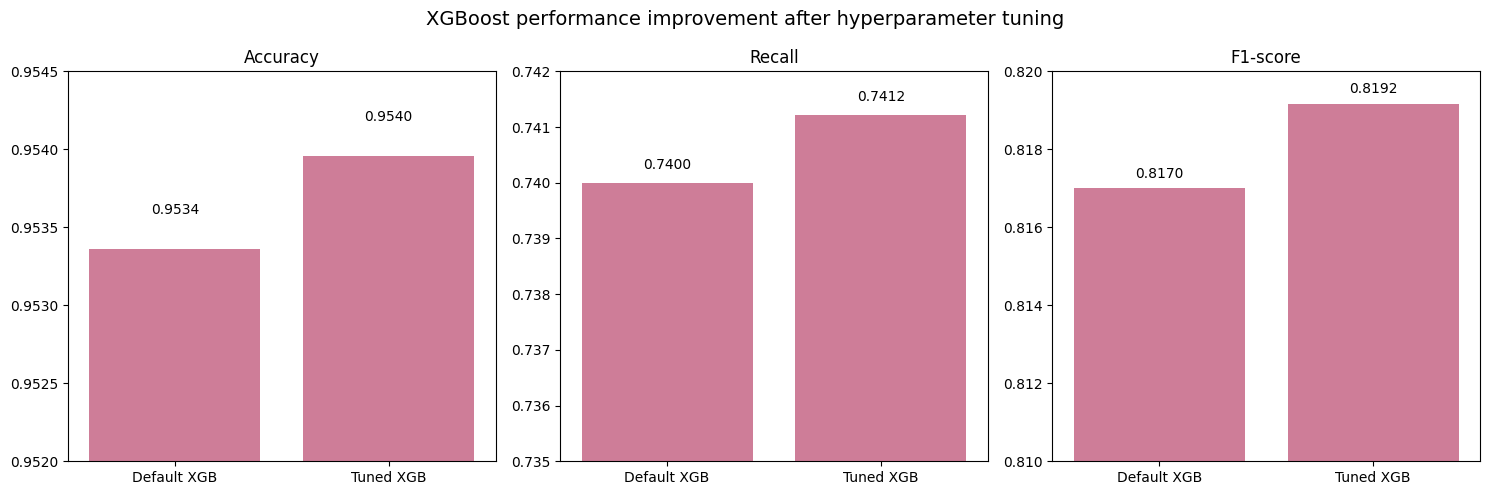

In [48]:
import seaborn as sns

metrics = {
    'Accuracy': [XGB_acc, accuracy_score(y_val, predict)],
    'Recall':   [XGB_rec, recall_score(y_val, predict)],
    'F1-score': [XGB_f1,  f1_score(y_val, predict)]
}

ylims = {
    'Accuracy': (0.952, 0.9545),
    'Recall':   (0.735, 0.742),
    'F1-score': (0.81, 0.82)
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (metric, values) in zip(axes, metrics.items()):
    sns.barplot(
        x=['Default XGB', 'Tuned XGB'],
        y=values,
        ax=ax, color='#DB7093'
    )
    ax.set_title(metric)
    ax.set_ylim(ylims[metric])

    for i, v in enumerate(values):
        ax.text(i, v + 0.0002, f"{v:.4f}", ha='center', va='bottom')

fig.suptitle('XGBoost performance improvement after hyperparameter tuning', fontsize=14)
plt.tight_layout()
plt.show()

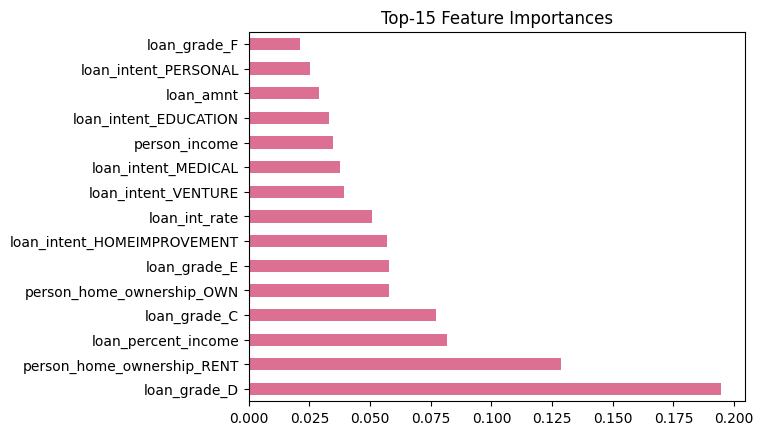

In [49]:
importances = grid.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns)\
            .sort_values(ascending=False).head(15)

feat_imp.plot(kind='barh', color='#DB7093')
plt.title('Top-15 Feature Importances')
plt.show()

Метрики на данных test

In [50]:
predict = grid.best_estimator_.predict(test)
ids = df_test['id']
pred_df = pd.DataFrame({'id':ids,
                        'loan_status':predict})
pred_df.to_csv('predictions.csv', index=False)

метрики с kaggle:
- Private Score 0.85785
- Public Score  0.87301